In [6]:
import numpy as np
import pandas as pd
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
import statsmodels.api as sm
warnings.filterwarnings("ignore")
pct_close = pd.read_parquet("../db/tw/pdata/close_pct.parquet")
pct_close_w = pct_close.resample("W-FRI").sum()

In [4]:
indexes = pct_close_w.index
tickers = pct_close_w.iloc[:, :].columns
indices = indexes[52:104]
forecast = np.zeros((len(indices), len(tickers)))
print(indices[0], indices[-1])
for index, date in enumerate(tqdm(indices, desc=f"arma model for top {len(tickers)}, enumerate by da")):
    pct_train = pct_close_w.loc[indexes[index]:date]
    for i in range(len(tickers)):
        series = pct_train[tickers[i]]
        if series.isna().any():
            prediction = 0
            print(tickers[i], "failed at", date)
            continue
            ###### ARIMA ma
        else:
            model = sm.tsa.arima.ARIMA(series, order=(2, 0, 0))
            model_fit = model.fit()
            prediction = model_fit.forecast().values[0]
        forecast[index, i] = prediction
factor = pd.DataFrame(forecast, columns=tickers, index=indices)


2020-01-03 00:00:00 2020-12-25 00:00:00


arma model for top 1013, enumerate by da: 100%|██████████| 52/52 [1:04:48<00:00, 74.78s/it]


In [7]:
factor.to_parquet('ARMA_2020_all_factor.parquet')

<Axes: title={'center': '10 quantile cumsum distribution'}, xlabel='da'>

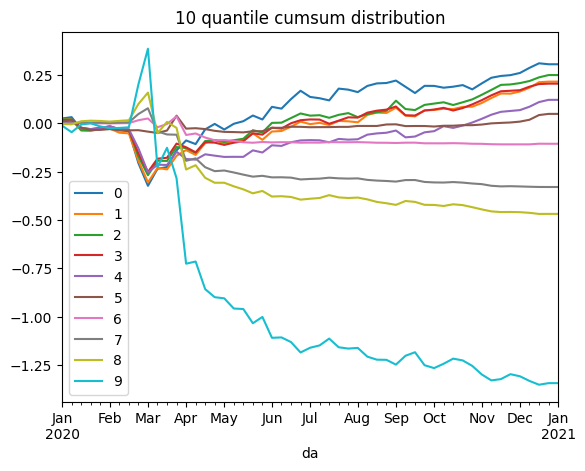

In [11]:
def get_demean_weighting(factor):
    df1 = factor.dropna(axis='columns', how='all').copy()
    demean = df1.sub(df1.mean(axis=1), axis=0)
    weighting = demean.div(demean.abs().sum(axis=1), axis=0)
    return weighting
def _reweighting_equal(weighting:pd.DataFrame):
    def equal_weight(row: pd.Series):
        count_larger_than_zero = (row != 0).sum()
        if count_larger_than_zero > 0:
            row = row.apply(lambda x: 1 / count_larger_than_zero if x > 0 else x)
        return row
    return weighting.apply(equal_weight, axis=1)
quantile = 10
time_length = len(factor)
quantile_column = [[None]*quantile]*time_length
quantile_df = pd.DataFrame(quantile_column)
for da in range(time_length):
    row = factor.iloc[da, :]
    col = row.sort_values(ascending=False).index
    for i in range(0, quantile):
        quantile_df.iloc[da, i] = list(col[i*int(len(row)/quantile):(i+1)*int(len(row)/quantile)])

pct_close_w_corres = pct_close_w[pct_close_w.columns.intersection(factor.columns)].shift(-2)

index = factor.index
quantiles = [None] * quantile
for qt_iter in range(quantile):
    quantile_1 = quantile_df.iloc[:, qt_iter]
    df_1 = factor.copy()
    for i in range(len(quantile_1)):
        df_1.loc[index[i], ~df_1.columns.isin(quantile_1[i])] = 0
    weighting_1 = _reweighting_equal(df_1)
    ret = pct_close_w_corres.loc[weighting_1.index[0]:] * weighting_1
    quantiles[qt_iter] = ret.sum(axis=1).cumsum()

quantilized_cumsum = pd.DataFrame(quantiles).T
quantilized_cumsum.loc['2020-01-01':'2021-01-01'].plot(title="10 quantile cumsum distribution")

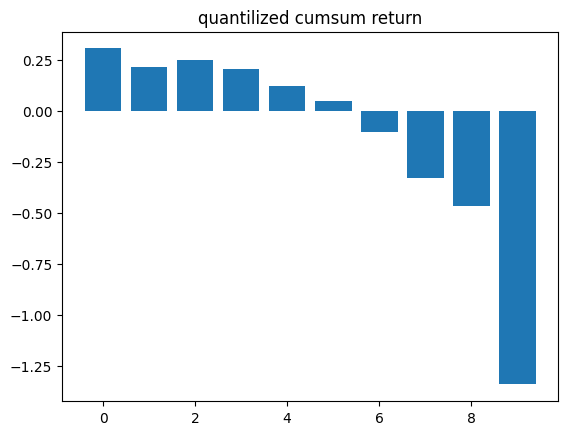

In [12]:
"""
0: AR預測值最高; 9: 最低 (number of stocks in thje stock pool: 1013; stocks per quantile: 100, 等權做多報酬)
"""
plt.bar(quantilized_cumsum.columns, quantilized_cumsum.loc['2020-01-01':'2021-01-01'].iloc[-1, :])
plt.title("quantilized cumsum return")
plt.show()
